# DELUX
## Backbone
We get the map status (of shape (8, 32, 32)) and fit into out backbone model to extract a 64-d state vector.
## Submodels
There is 2 submodels(city tile and worker model, i omit the cart model to ease the training) attach to this backbone which will receive the state vector, game stats and the corresponding state of the unit to determine the action.

## Reward function
The reward function is define as 
$ \text{Reward, }R = \text{Agent's score} - (\text{difficulty constant}) * \text{opponent's score} $ , where difficulty constant is currently set to 0.1 and

$ \text{Score, }S = 3(\text{number of city tiles}) + \text{number of units} + \text{research points} / 100 + (\text{turns survived}) / 360 - (\text{opponent's score}) $

I think the reward function can be modified or can replaced by a neural network trained based on others' gameplay.

## Replay buffer 
We save the tuple (state, action, reward, next_state) in a buffer for the model to relearn whether an action is good or bad. 

# TODO 
- Build planning model for the units
    - application of some kind of mask [X]
    - sick annotations [X]
- Save the current best model (target model), and train the model until it beats the target model (to avoid it learns backward)
- Define penalty for invalid moves
    - off map moves
    - build city without enough resources
    - collsion or move inside opponent city
- Batch stuff to accelerate on GPU
- Self play ? and record winning side's state in the replay buffer?

In [1]:
!pip freeze > requirements.txt

# Import Libraries =.=

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES, Position
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math
import sys
import copy
from collections import deque
import random
import time
from tqdm.notebook import tqdm_notebook
import gc

In [2]:
#!node --version
#!pip install kaggle-environments -U
from kaggle_environments import make

No pygame installed, ignoring import


In [4]:
#!cp -r ../input/lux-ai-2021/* .
#!cp -r ../input/baselinemodelisaac150-1/* .

In [4]:
game_state = None
def agent(observation, configuration):
    global game_state

    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
    else:
        game_state._update(observation["updates"])
    
    actions = []

    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height
    
    return actions

In [5]:
env = make("lux_ai_2021", configuration={"seed": random.randint(0, 100000000), "loglevel": 2}, debug=True)
steps = env.run([agent, "simple_agent"])
env.render(mode="ipython", width=1200, height=800)

# Data Exploration =.=

- get resource map ( 3 layers ）
- get player and  oppponent cities and units map
    - player cities, and units, resources, research points

In [5]:
# maybe try to convert to tf function in the future
def get_map(game_state):
    map_size = game_state.map.height
    resource_map = np.zeros((3, map_size, map_size), np.float32)
    road_map = np.zeros((1, map_size, map_size), np.float32)
    players_map = np.zeros((4, map_size, map_size), np.float32)
    player = game_state.players[0]
    opponent = game_state.players[1]
    fuels = np.array([0, 0], np.float32)
    for y in range(map_size):
        for x in range(map_size):
            tile = game_state.map.get_cell(x, y)
            if not tile.has_resource():
                if tile.road != 0.0:
                    road_map[0, y, x] = tile.road
                continue
            if(tile.resource.type == 'wood'):
                resource_map[0, y, x] += tile.resource.amount
            elif(tile.resource.type == 'coal'):
                resource_map[1, y, x] += tile.resource.amount
            else:
                resource_map[2, y, x] += tile.resource.amount
    
    for city in player.cities.values():
        fuels[0] += city.fuel
        for city_tile in city.citytiles:
            players_map[0, city_tile.pos.y, city_tile.pos.x] = 1
    for city in opponent.cities.values():
        fuels[1] += city.fuel
        for city_tile in city.citytiles:
            players_map[1, city_tile.pos.y, city_tile.pos.x] = 1
    for unit in player.units:
        players_map[2, unit.pos.y, unit.pos.x] = 1
    for unit in opponent.units:
        players_map[3, unit.pos.y, unit.pos.x] = 1
    
    research_points = np.array([player.research_points, opponent.research_points], np.float32)
    tech_levels = np.array([player.researched_coal(), player.researched_uranium(), opponent.researched_coal(), opponent.researched_uranium()], np.float32)
    
    padding = (32-resource_map.shape[1])//2
    resource_map = np.pad(resource_map, [[0,0], [padding, padding], [padding, padding]])
    road_map = np.pad(road_map, [[0,0], [padding, padding], [padding, padding]])
    players_map = np.pad(players_map, [[0,0], [padding, padding], [padding, padding]])
    
    return resource_map, road_map, players_map, np.concatenate([fuels, research_points, tech_levels])

In [6]:
print(game_state)

In [7]:
resource_map, road_map, players_map, game_stats = get_map(game_state)

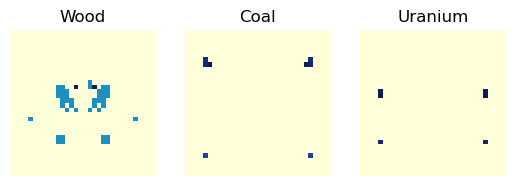

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

g1 = sns.heatmap(resource_map[0], cmap="YlGnBu", ax=ax1, cbar=False)
g1.set_title("Wood")
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticks([])
g1.set_xticks([])
g1.set(adjustable='box', aspect='equal')
g2 = sns.heatmap(resource_map[1], cmap="YlGnBu", ax=ax2, cbar=False)
g2.set_title("Coal")
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g2.set_xticks([])
g2.set(adjustable='box', aspect='equal')
g3 = sns.heatmap(resource_map[2], cmap="YlGnBu", ax=ax3, cbar=False)
g3.set_title("Uranium")
g3.set_ylabel('')
g3.set_xlabel('')
g3.set_yticks([])
g3.set_xticks([])
g3.set(adjustable='box', aspect='equal')

plt.show()

[None, None]

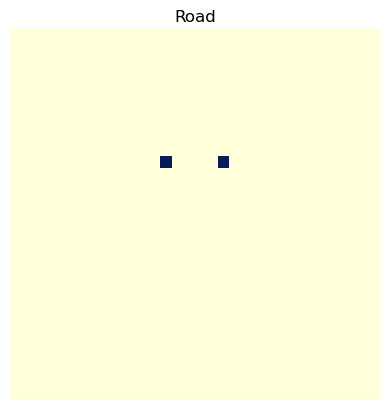

In [9]:
fig, ax = plt.subplots()

g1 = sns.heatmap(road_map[0], cmap="YlGnBu", ax=ax, cbar=False)
g1.set_title("Road")
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticks([])
g1.set_xticks([])
g1.set(adjustable='box', aspect='equal')

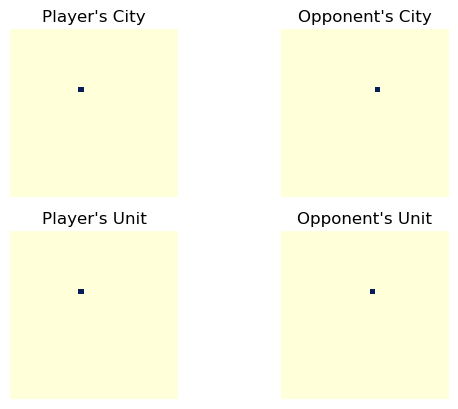

In [10]:
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2)

g1 = sns.heatmap(players_map[0], cmap="YlGnBu", ax=ax1, cbar=False)
g1.set_title("Player's City")
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticks([])
g1.set_xticks([])
g1.set(aspect='equal')
g2 = sns.heatmap(players_map[1], cmap="YlGnBu", ax=ax2, cbar=False)
g2.set_title("Opponent's City")
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g2.set_xticks([])
g2.set(aspect='equal')
g3 = sns.heatmap(players_map[2], cmap="YlGnBu", ax=ax3, cbar=False)
g3.set_title("Player's Unit")
g3.set_ylabel('')
g3.set_xlabel('')
g3.set_yticks([])
g3.set_xticks([])
g3.set(aspect='equal')
g4 = sns.heatmap(players_map[3], cmap="YlGnBu", ax=ax4, cbar=False)
g4.set_title("Opponent's Unit")
g4.set_ylabel('')
g4.set_xlabel('')
g4.set_yticks([])
g4.set_xticks([])
g4.set(aspect='equal')

plt.show()

# Planning Exploration

In [11]:
state_map = tf.random.uniform([8, 32, 32])
state_map2 = tf.random.uniform([8, 32, 32])
mse = tf.keras.losses.MeanSquaredError()
mse(state_map, state_map2)

<tf.Tensor: shape=(), dtype=float32, numpy=0.16481939>

In [12]:
enc = tf.keras.layers.Conv2D(1, (1, 1))
state_map = tf.transpose(state_map, perm=[2, 1, 0])
state_map = tf.expand_dims(state_map, axis=0)
state_map = enc(state_map)
state_map.shape
state_map = tf.squeeze(state_map, [0])
state_map = tf.transpose(state_map, perm=[2, 1, 0])
state_map = tf.squeeze(state_map, [0])

state_map = state_map - tf.math.reduce_min(state_map)
state_map = state_map / tf.math.reduce_max(state_map)

[None, None]

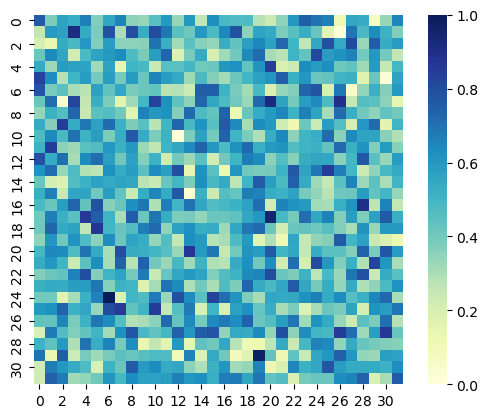

In [13]:
fig, ax = plt.subplots()

g1 = sns.heatmap(state_map, cmap="YlGnBu", ax=ax, cbar=True)
g1.set_ylabel('')
g1.set_xlabel('')
# g1.set_yticks([])
# g1.set_xticks([])
g1.set(adjustable='box', aspect='equal')

In [14]:
distance_mask = np.zeros(shape=(32, 32))
x = 20
y = 0
for i in range(len(distance_mask)):
    for j in range(len(distance_mask)):
        distance_mask[i, j] = 1 - ((i - y)**2 + (j - x)**2) / 2048

[None, None]

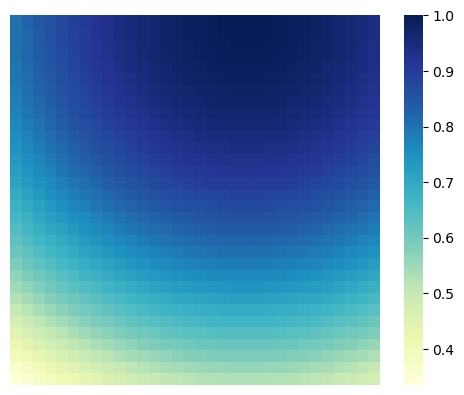

In [15]:
fig, ax = plt.subplots()

g1 = sns.heatmap(distance_mask, cmap="YlGnBu", ax=ax, cbar=True)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticks([])
g1.set_xticks([])
g1.set(adjustable='box', aspect='equal')

In [16]:
distance_masked = distance_mask * state_map

[None, None]

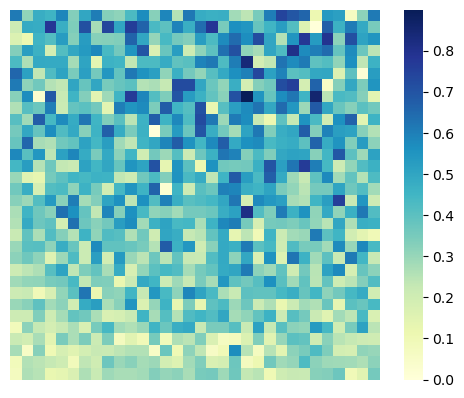

In [17]:
fig, ax = plt.subplots()

g1 = sns.heatmap(distance_masked, cmap="YlGnBu", ax=ax, cbar=True)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticks([])
g1.set_xticks([])
g1.set(adjustable='box', aspect='equal')

In [18]:
map_size = 24
map_mask = np.zeros((32, 32))
map_mask[(32-map_size)//2:(32+map_size)//2, (32-map_size)//2:(32+map_size)//2] = 1.0

[None, None]

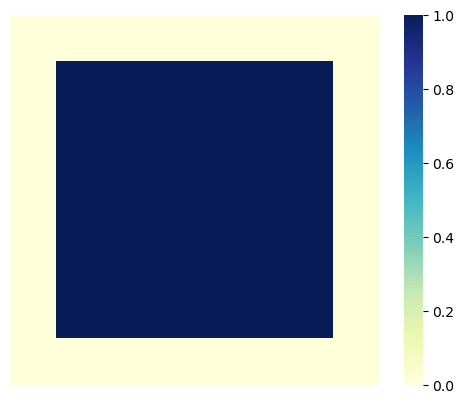

In [19]:
fig, ax = plt.subplots()

g1 = sns.heatmap(map_mask, cmap="YlGnBu", ax=ax, cbar=True)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_yticks([])
g1.set_xticks([])
g1.set(adjustable='box', aspect='equal')

In [20]:
map_masked = distance_masked * map_mask

[None, None]

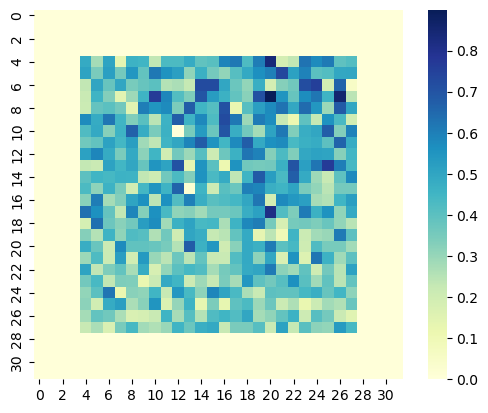

In [21]:
fig, ax = plt.subplots()

g1 = sns.heatmap(map_masked, cmap="YlGnBu", ax=ax, cbar=True)
g1.set_ylabel('')
g1.set_xlabel('')
# g1.set_yticks([])
# g1.set_xticks([])
g1.set(adjustable='box', aspect='equal')

In [22]:
index = tf.argmax(tf.reshape(map_masked, 1024))
x, y = index % 32, index // 32
map_masked.numpy()[y, x] == tf.reduce_max(map_masked)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

# Model Building
try to build a Conv and dense network based on the given data

## List of expected actions
- CityTile actions
1. Build Worker - Build Worker unit on top of this CityTile (cannot build a worker if current number of owned workers + carts equals the number of owned CityTiles)
1. Build Cart - Build Carts unit on top of this CityTile (cannot build a cart if there are if current number of owned workers + carts equals the number of owned CityTiles)
1. Research - Increase your team’s Research Points by 1

- Unit actions
1. Worker
    - Move(4) - North, East, South, West, Center.
    - Pillage(1) - Reduce the Road level of the tile the unit is on by 0.5
    - Transfer(1, we are not using this for now because it involves extra numeric outputs) - Send any amount of a single resource-type from own cargo to another (start-of-turn) adjacent Unit, up to the latter's cargo-capcity. Excess is returned to the original unit.
    - Build CityTile(1) - Build a CityTile right under this worker
1. Cart
    - Move(4) - Move the unit in one of 5 directions, North, East, South, West, Center.
    - Transfer(1, we are not using this for now because it involves extra numeric outputs) - Send any amount of a single resource-type from own cargo to another (start-of-turn) adjacent Unit

In [23]:
# class CartNet(tf.keras.Model):
#     def __init__(self):
#         super(CartNet, self).__init__()
        
#         self.dense1 = tf.keras.layers.Dense(128)
#         self.bn1 = tf.keras.layers.BatchNormalization()
        
#         self.dense2 = tf.keras.layers.Dense(64)
#         self.bn2 = tf.keras.layers.BatchNormalization()

#         self.dense3 = tf.keras.layers.Dense(32)
#         self.bn3 = tf.keras.layers.BatchNormalization()
        
#         self.dense4 = tf.keras.layers.Dense(5)
    
#     def call(self, input_tensor, state_map, training=False):
#         x = tf.keras.layers.InputLayer((1, 270))(input_tensor)
#         x = self.dense1(x)
#         x = self.bn1(x, training)
#         x = tf.nn.leaky_relu(x)
        
#         x = self.dense2(x)
#         x = self.bn2(x, training)
#         x = tf.nn.leaky_relu(x)
        
#         x = self.dense3(x)
#         x = self.bn3(x, training)
#         x = tf.nn.leaky_relu(x)
        
#         output_vector = self.dense4(x)
        
#         return output_vector

class WorkerNet(tf.keras.Model):
    def __init__(self):
        super(WorkerNet, self).__init__()
        
        self.dense1 = tf.keras.layers.Dense(16)
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.dense2 = tf.keras.layers.Dense(16)
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.dense3 = tf.keras.layers.Dense(8)
        self.bn3 = tf.keras.layers.BatchNormalization()
        
        self.dense4 = tf.keras.layers.Dense(3, activation='softmax')
    # rework
    def call(self, input_tensor, state_map, training=False):
        x = tf.keras.layers.InputLayer((1, 29))(input_tensor)
        x = self.dense1(x)
        x = self.bn1(x, training)
        x = tf.nn.leaky_relu(x)
        
        x = self.dense2(x)
        x = self.bn2(x, training)
        x = tf.nn.leaky_relu(x)
        
        x = self.dense3(x)
        x = self.bn3(x, training)
        x = tf.nn.leaky_relu(x)
        
        output_vector = self.dense4(x)
        
        return output_vector
    
    def move(self, unit_x, unit_y, state_map, training=False):
        state_map = tf.transpose(state_map, perm=[2, 1, 0])
        state_map = tf.expand_dims(state_map, axis=0)
        state_map = self.Conv1(state_map)
        state_map = tf.transpose(state_map, perm=[0, 3, 2, 1])
        state_map = tf.squeeze(state_map, [0, 1])
        state_map = state_map - tf.math.reduce_min(state_map)
        state_map = state_map / tf.math.reduce_max(state_map)
        
        distance_mask = np.zeros(shape=(32, 32))
        for i in range(len(distance_mask)):
            for j in range(len(distance_mask)):
                distance_mask[i, j] = 1 - ((i - unit_y)**2 + (j - unit_x)**2) / 2048
        
        map_mask = np.zeros((32, 32))
        map_mask[(32-map_size)//2:(32+map_size)//2, (32-map_size)//2:(32+map_size)//2] = 1.0

class CityNet(tf.keras.Model):
    def __init__(self):
        super(CityNet, self).__init__()
        
        self.dense1 = tf.keras.layers.Dense(16)
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.dense2 = tf.keras.layers.Dense(16)
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.dense3 = tf.keras.layers.Dense(8)
        self.bn3 = tf.keras.layers.BatchNormalization()
        
        self.dense4 = tf.keras.layers.Dense(3, activation='softmax')
    
    def call(self, input_tensor, state_map, training=False):
        x = tf.keras.layers.InputLayer((1, 26))(input_tensor)
        x = self.dense1(x)
        x = self.bn1(x, training)
        x = tf.nn.leaky_relu(x)
        
        x = self.dense2(x)
        x = self.bn2(x, training)
        x = tf.nn.leaky_relu(x)
        
        x = self.dense3(x)
        x = self.bn3(x, training)
        x = tf.nn.leaky_relu(x)
        
        output_vector = self.dense4(x)
        
        return output_vector

In [24]:
class ResnetIdentityBlock(tf.keras.Model):
    def __init__(self, kernel_size, num_filters):
        super(ResnetIdentityBlock, self).__init__()

        self.conv2a = tf.keras.layers.Conv2D(num_filters, (1, 1))
        self.bn2a = tf.keras.layers.BatchNormalization()

        self.conv2b = tf.keras.layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn2b = tf.keras.layers.BatchNormalization()

        self.conv2c = tf.keras.layers.Conv2D(num_filters, (1, 1))
        self.bn2c = tf.keras.layers.BatchNormalization()

    def call(self, input_tensor, training=False):
        x = self.conv2a(input_tensor)
        x = self.bn2a(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv2b(x)
        x = self.bn2b(x, training=training)
        x = tf.nn.leaky_relu(x)

        x = self.conv2c(x)
        x = self.bn2c(x, training=training)
        x += input_tensor
        return tf.nn.leaky_relu(x)

In [25]:
class DeLux(tf.keras.Model):
    def __init__(self):
        super(DeLux, self).__init__()

        self.InputLayer = tf.keras.layers.InputLayer((32, 32, 8))
        self.ConvPre = tf.keras.layers.Conv2D(2, (1, 1))
        self.ResBlock1 = ResnetIdentityBlock(7, 2)
        self.ResBlock2 = ResnetIdentityBlock(7, 2)
        self.ResBlock3 = ResnetIdentityBlock(7, 2)
        self.Conv1 = tf.keras.layers.Conv2D(4, (5, 5))
        self.Conv2 = tf.keras.layers.Conv2D(8, (5, 5))
        self.MaxPool = tf.keras.layers.MaxPooling2D()
        self.Flat = tf.keras.layers.Flatten()
        self.Dense1 = tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu)
        self.Dense2 = tf.keras.layers.Dense(16, activation=tf.nn.leaky_relu)
        
        self.ConvWorker = tf.keras.layers.Conv2D(1, (1, 1))
        self.BNWorker = tf.keras.layers.BatchNormalization()
        
        self.game_stats = None
        self.state_map = None 
        self.state_vector = None
        self.history = None
        self.map_size = 32
        
        self.CityNet = CityNet()
#         self.CityNet.build((1, 18))
        self.WorkerNet = WorkerNet()
#         self.WorkerNet.build((1, 22))
#         self.CartNet = CartNet()
#         self.CartNet.build((1, 22))
    
    def call(self, inputs, training=False):
        self.game_stats = tf.expand_dims(inputs[1], axis=0)
        transposed_inputs = tf.transpose(inputs[0], perm=[2, 1, 0])
        transposed_inputs = tf.expand_dims(transposed_inputs, axis=0)
        
#         x = self.InputLayer(transposed_inputs)
        x = self.ConvPre(transposed_inputs)
        x = self.ResBlock1(x, training)
        x = self.ResBlock2(x, training)
        x = self.ResBlock3(x, training)
        self.state_map = tf.transpose(tf.squeeze(x, [0]), perm=[2, 1, 0])
        
        x = self.Conv1(x)       # (1, 28, 28, 4)
        x = self.MaxPool(x)     # (1, 14, 14, 4)
        x = self.Conv2(x)       # (1, 10, 10, 8)
        x = self.MaxPool(x)     # (1, 5, 5, 8)
        
        # transposed_outputs = tf.squeeze(x, [0])
        # transposed_outputs = tf.transpose(transposed_outputs, perm=[2, 1, 0])
        
        x = self.Flat(x)
        x = self.Dense1(x)
        self.state_vector = self.Dense2(x)
        
        return self.state_vector
      
    def reset(self):
        self.game_stats = None
        self.state_map = None 
        self.state_vector = None
        self.history = None

    
    def city_call(self, input_tensor, training=False):
        input_tensor = tf.expand_dims(input_tensor, axis=0)
        input_tensor = tf.concat([self.state_vector, self.game_stats, input_tensor], axis=1)
        output = self.CityNet(input_tensor,training)
        return output
    
    def worker_call(self, input_tensor, training=False):
        input_tensor = tf.expand_dims(input_tensor, axis=0)
        input_tensor = tf.concat([self.state_vector, self.game_stats, input_tensor], axis=1)
        output = self.WorkerNet(input_tensor, training)
        return output
    
#     def cart_call(self, input_tensor, training=False):
#         input_tensor = tf.expand_dims(input_tensor, axis=0)
#         input_tensor = tf.concat([self.state_vector, self.game_stats, input_tensor], axis=1)
#         output = self.CartNet(input_tensor, self.state_map, self.map_size, training)
#         return output
    
    def worker_move(self, unit_x, unit_y, training=False):
        unit_x, unit_y = unit_x + (32 - self.map_size) // 2, unit_y + (32 - self.map_size) // 2
        
        state_map = tf.transpose(self.state_map, perm=[2, 1, 0])
        state_map = tf.expand_dims(state_map, axis=0)
        state_map = self.ConvWorker(state_map)
        state_map = self.BNWorker(state_map)
        state_map = tf.transpose(state_map, perm=[0, 3, 2, 1])
        state_map = tf.squeeze(state_map, [0, 1])
#         state_map = state_map - tf.math.reduce_min(state_map)
#         state_map = state_map / tf.math.reduce_max(state_map)
        
        distance_mask = np.zeros(shape=(32, 32))
        for i in range(len(distance_mask)):
            for j in range(len(distance_mask)):
                distance_mask[i, j] = 1 - ((i - unit_y)**2 + (j - unit_x)**2) / 2048
        
        map_mask = np.zeros((32, 32))
        map_mask[(32-self.map_size)//2:(32+self.map_size)//2, (32-self.map_size)//2:(32+self.map_size)//2] = 1.0
        
        state_map = state_map * distance_mask * map_mask
        return state_map
    
#     def cart_move(self, unit_x, unit_y, training=False):
#         unit_x, unit_y = unit_x + (32 - self.map_size) // 2, unit_y + (32 - self.map_size) // 2
        
#         state_map = tf.transpose(self.state_map, perm=[2, 1, 0])
#         state_map = tf.expand_dims(state_map, axis=0)
#         state_map = self.ConvWorker(state_map)
#         state_map = tf.transpose(state_map, perm=[0, 3, 2, 1])
#         state_map = tf.squeeze(state_map, [0, 1])
#         state_map = state_map - tf.math.reduce_min(state_map)
#         state_map = state_map / tf.math.reduce_max(state_map)
        
#         distance_mask = np.zeros(shape=(32, 32))
#         for i in range(len(distance_mask)):
#             for j in range(len(distance_mask)):
#                 distance_mask[i, j] = 1 - ((i - unit_y)**2 + (j - unit_x)**2) / 2048
        
#         map_mask = np.zeros((32, 32))
#         map_mask[(32-self.map_size)//2:(32+self.map_size)//2, (32-self.map_size)//2:(32+self.map_size)//2] = 1.0
        
#         state_map = state_map * distance_mask * map_mask
#         index = tf.argmax(tf.reshape(map_masked, 1024))
#         x, y = index % 32, index // 32
        
#         return x, y

In [26]:
class DQNAgent:
    def __init__(self, saved_weights_path=None):
        self.memory = deque(maxlen=1800) # maximum of 5 games 

        self.gamma = 0.95 # discount factor

        self.epsilon = 1.0
        self.epsilon_decay = 0.9999
        self.epsilon_min = 0.001

        self.learning_rate = 0.01
        self.model = DeLux()
        self.model.__init__()
        
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy()
        self.loss_fn2 = tf.keras.losses.MeanSquaredError()
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.map_size = 32
        if saved_weights_path is not None:
            self.model((np.zeros((8, 32, 32)), np.zeros((8,))))
            self.model.load_weights(saved_weights_path)
    
    def _get_state(self, game_state):
        resource_map, road_map, players_map, game_stats = get_map(game_state)

        tf_resource_map = tf.constant(resource_map)
        tf_road_map = tf.constant(road_map)
        tf_players_map = tf.constant(players_map)
        tf_game_stats = tf.constant(game_stats)

        tf_map_states = tf.concat([tf_resource_map, tf_road_map, tf_players_map], axis=0)
        return (tf_map_states, tf_game_stats)
  
    def memorize(self, state, actions, reward, next_state, done):
#         _state = copy.deepcopy(state)
#         _next_state = copy.deepcopy(next_state)
        self.memory.append((state, actions, reward, next_state, done))
    
    def save_weights(self, epoch):
        self.model.save_weights(f'./checkpoints/baseline-model/checkpoint-{epoch}e')
    
    def reset(self):
        self.model.reset()
        
    def act(self, game_state, training=False):
        actions = []
        translated_actions = []
        player = game_state.players[0]
        tf_state = self._get_state(game_state)
        self.model.map_size = game_state.map_height
        self.model(tf_state)
        
        for city in player.cities.values():
            for city_tile in city.citytiles:
                if not city_tile.can_act():
                    continue
                # should provide models the information of the city location and other to make prediction
                if np.random.rand() <= self.epsilon and training:
                    output = np.zeros(3)
                    output[np.random.randint(0, 3)] = 1
                    output = tf.constant(output)
                    self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
                else:
                    input_tensor = tf.constant([city_tile.pos.x, city_tile.pos.y], dtype=tf.float32)
                    output = self.model.city_call(input_tensor)
                    output = tf.squeeze(output)
                actions.append((output, "city"))
                if tf.argmax(output) == 0:
                    translated_actions.append(city_tile.research())
                elif tf.argmax(output) == 1:
                    translated_actions.append(city_tile.build_worker())
                else:
                    translated_actions.append(city_tile.build_cart())
        for unit in player.units:
            if not unit.can_act():
                continue
            if unit.is_worker():
                # exclude transfer function
                state_map = self.model.worker_move(unit.pos.x, unit.pos.y)
                if np.random.rand() <= self.epsilon and training:
                    target_x = np.random.randint(0, self.map_size)
                    target_y = np.random.randint(0, self.map_size)
                    self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
                else:
                    index = tf.argmax(tf.reshape(state_map, 1024))
                    target_x, target_y = index % 32, index // 32
                    target_x, target_y = target_x - (32 - self.map_size) // 2, target_y - (32 - self.map_size) // 2
                if unit.pos.x == target_x and unit.pos.y == target_y:
                    if np.random.rand() <= self.epsilon and training:
                        output = np.zeros(3)
                        output[np.random.randint(0, 3)] = 1
                        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
                    else:
                        curr_q_value = state_map[unit.pos.y, unit.pos.x].numpy()
                        input_tensor = tf.constant([curr_q_value, unit.get_cargo_space_left(), unit.cargo.wood, unit.cargo.coal, unit.cargo.uranium], dtype=tf.float32)
                        output = self.model.worker_call(input_tensor)
                        output = tf.squeeze(output)
                    actions.append((output, "worker_action"))
                    if tf.argmax(output) == 0:
                        translated_actions.append(unit.build_city())
                    elif tf.argmax(output) == 1:
                        translated_actions.append(unit.pillage())
                    else:
                        pass
                else:
                    actions.append(((target_x, target_y), "worker_move"))
                    translated_actions.append(annotate.x(target_x, target_y))
                    translated_actions.append(annotate.line(unit.pos.x, unit.pos.y, target_x, target_y))
                    translated_actions.append(unit.move(unit.pos.direction_to(Position(target_x, target_y))))
#             else: 
#                 # exclude transfer function
#                 if np.random.rand() <= self.epsilon and training:
#                     target_x = np.random.randint(0, self.map_size)
#                     target_y = np.random.randint(0, self.map_size)
#                     q_value = np.random.random()
#                     self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
#                 else:
#                     state_map = self.model.cart_move(unit.pos.x, unit.pos.y)
#                     index = tf.argmax(tf.reshape(state_map, 1024))
#                     target_x, target_y = index % 32, index // 32
#                     target_x, target_y = target_x - (32 - self.map_size) // 2, target_y - (32 - self.map_size) // 2
#                     q_value = tf.reduce_max(state_map)
#                 if unit.pos.x == target_x and unit.pos.y == target_y:
#                     pass
#                 else:
#                     actions.append(((target_x, target_y), "cart_move"))
#                     translated_actions.append(annotate.x(target_x, target_y))
#                     translated_actions.append(annotate.line(unit.pos.x, unit.pos.y, target_x, target_y))
#                     translated_actions.append(unit.move(unit.pos.direction_to(Position(target_x, target_y))))
        
        return actions, translated_actions
  
    def replay(self, batch_size):
        
        loss = 0
        
        minibatch = random.sample(self.memory, batch_size)

        for state, actions, reward, next_state, done in tqdm_notebook(minibatch, desc = "Sampling Progress"):
            city_tiles = []
            workers = []
#             carts = []
            player = state.players[0]
            num_actions = len(actions) if len(actions) != 0 else 1
        
            for city in player.cities.values():
                for city_tile in city.citytiles:
                    if not city_tile.can_act():
                        continue
                    city_tiles.append(city_tile)
            for unit in player.units:
                if not unit.can_act():
                    continue
                if unit.is_worker():
                    workers.append(unit)
#                 else:
#                     carts.append(unit)
        
            if done:
                target = reward # / num_actions
                tf_state = self._get_state(state)
                for i in range(len(actions)):
                    prediction = None
                    prediction_state_map = None
                    with tf.GradientTape() as tape:
                        self.model(tf_state, training=True)
                        if actions[i][1] == 'city' and city_tiles:
                            city_tile = city_tiles.pop(0)
                            input_tensor = tf.constant([city_tile.pos.x, city_tile.pos.y], dtype=tf.float32)
                            prediction = self.model.city_call(input_tensor, training=True)[0]
                            target = target_city 
                        elif "worker" in actions[i][1]:
                            unit = workers.pop(0)
                            prediction_state_map = self.model.worker_move(unit.pos.x, unit.pos.y, training=True)
                            if actions[i][1] == 'worker_action' and workers:          
                                curr_q_value = prediction_state_map[unit.pos.y, unit.pos.x].numpy()
                                input_tensor = tf.constant([curr_q_value, unit.get_cargo_space_left(), unit.cargo.wood, unit.cargo.coal, unit.cargo.uranium], dtype=tf.float32)
                                prediction = self.model.worker_call(input_tensor, training=True)[0]
#                         elif actions[i][1] == 'carts' and carts:
#                             unit = carts.pop(0)
#                             input_tensor = tf.constant([unit.pos.x, unit.pos.y, unit.get_cargo_space_left(), unit.cargo.wood, unit.cargo.coal, unit.cargo.uranium], dtype=tf.float32)
#                             prediction = self.model.cart_call(input_tensor, training=True)[0]
                        elif actions[i][1] == 'worker_move' and workers:
                            unit = workers.pop(0)
                            input_tensor = tf.constant([unit.pos.x, unit.pos.y, unit.get_cargo_space_left(), unit.cargo.wood, unit.cargo.coal, unit.cargo.uranium], dtype=tf.float32)
                            prediction = self.model.worker_call(input_tensor, training=True)[0]
                            target = target_worker
                            prediction_state_map = self.model.worker_move(unit.pos.x, unit.pos.y, training=True)
                        
                        if prediction is None:
                            continue
                        target_actions = prediction.numpy()
                        target_actions[tf.argmax(actions[i][0]).numpy()] = target
                        target_actions = tf.constant(target_actions)
                        loss_value = self.loss_fn(target_actions, prediction)
                        if prediction_state_map is not None:
                            target_state_map = prediction_state_map.numpy()
                            target_state_map[actions[i][0][1], actions[i][0][0]] = target
                            target_state_map = tf.constant(target_state_map)
                            loss_value += self.loss_fn2(target_state_map, prediction_state_map)
                        loss += loss_value
                    
                    gradients = tape.gradient(loss_value, tape.watched_variables())
                    self.optimizer.apply_gradients(
                        (grad, var)
                        for (grad, var) in zip(gradients, tape.watched_variables())
                        if grad is not None)
            else:
                next_player = next_state.players[0]
                target_city = 0
                target_worker = 0
#                 target_cart = 0
                target_move = 0
                
                tf_next_state = self._get_state(next_state)
                self.model(tf_next_state, training=True)
                
                for city in next_player.cities.values():
                    for city_tile in city.citytiles:
                        if not city_tile.can_act():
                            continue
                        input_tensor = tf.constant([city_tile.pos.x, city_tile.pos.y], dtype=tf.float32)
                        target_city = max(target_city, np.amax(self.model.city_call(input_tensor, training=False).numpy()))
                for unit in next_player.units:
                    if not unit.can_act():
                        continue
                    if unit.is_worker():
                        state_map = self.model.worker_move(unit.pos.x, unit.pos.y, training=False)
                        target_move = tf.reduce_max(state_map)
                        next_q_value = state_map[unit.pos.y, unit.pos.x].numpy()
                        input_tensor = tf.constant([next_q_value, unit.get_cargo_space_left(), unit.cargo.wood, unit.cargo.coal, unit.cargo.uranium], dtype=tf.float32)
                        target_worker = max(target_worker, np.amax(self.model.worker_call(input_tensor, training=False).numpy()))
#                     else:
#                         input_tensor = tf.constant([unit.pos.x, unit.pos.y, unit.get_cargo_space_left(), unit.cargo.wood, unit.cargo.coal, unit.cargo.uranium], dtype=tf.float32)
#                         target_cart = max(target_cart, np.amax(self.model.cart_call(input_tensor, training=False).numpy()))
                
                target_city = (reward + self.gamma * target_city) # / num_actions
                target_worker = (reward + self.gamma * target_worker) # / num_actions
#                 target_cart = (reward + self.gamma * target_cart) / num_actions
                target_move = (reward + self.gamma * target_move) # / num_actions

                for i in range(len(actions)):
                    prediction = None
                    prediction_state_map = None
                    with tf.GradientTape() as tape:
                        tf_state = self._get_state(state)
                        self.model(tf_state, training=True)
                        if actions[i][1] == 'city' and city_tiles:
                            city_tile = city_tiles.pop(0)
                            input_tensor = tf.constant([city_tile.pos.x, city_tile.pos.y], dtype=tf.float32)
                            prediction = self.model.city_call(input_tensor, training=True)[0]
                            target = target_city 
                        elif "worker" in actions[i][1]:
                            unit = workers.pop(0)
                            prediction_state_map = self.model.worker_move(unit.pos.x, unit.pos.y, training=True)
                            if actions[i][1] == 'worker_action' and workers:          
                                curr_q_value = prediction_state_map[unit.pos.y, unit.pos.x].numpy()
                                input_tensor = tf.constant([curr_q_value, unit.get_cargo_space_left(), unit.cargo.wood, unit.cargo.coal, unit.cargo.uranium], dtype=tf.float32)
                                prediction = self.model.worker_call(input_tensor, training=True)[0]
                                target = target_worker
#                         elif actions[i][1] == 'cart' and carts:
#                             unit = carts.pop(0)
#                             input_tensor = tf.constant([unit.pos.x, unit.pos.y, unit.get_cargo_space_left(), unit.cargo.wood, unit.cargo.coal, unit.cargo.uranium], dtype=tf.float32)
#                             prediction = self.model.cart_call(input_tensor, training=True)[0]
#                             target = target_cart
                        
                        if prediction is None:
                            continue
                        target_actions = prediction.numpy()
                        target_actions[tf.argmax(actions[i][0]).numpy()] = target
                        target_actions = tf.constant(target_actions)
                        loss_value = self.loss_fn(target_actions, prediction)
                        if prediction_state_map is not None:
                            target_state_map = prediction_state_map.numpy()
                            target_state_map[actions[i][0][1], actions[i][0][0]] = target_move
                            target_state_map = tf.constant(target_state_map)
                            loss_value += self.loss_fn2(target_state_map, prediction_state_map)
                        loss += loss_value
                    
                    gradients = tape.gradient(loss_value, tape.watched_variables())
                    self.optimizer.apply_gradients(
                        (grad, var)
                        for (grad, var) in zip(gradients, tape.watched_variables())
                        if grad is not None)
        print(f"Total loss: {loss}")

In [27]:
!ls

__init__.py                 lux-ai-tensorflow-dqn.ipynb
agent.py                    main.py
lux


# Before train test

In [28]:
# define hand code agent
from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES, Position
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math
import sys
import numpy as np

directions_dict = {
    'c': (0,0),
    's': (0,1),
    'n': (0,-1),
    'w': (-1,0),
    'e': (1,0),
}

def get_random_step():
    return np.random.choice(['s','n','w','e'])

def find_resources(game_state):
    resource_tiles: list[Cell] = []
    width, height = game_state.map_width, game_state.map_height
    for y in range(height):
        for x in range(width):
            cell = game_state.map.get_cell(x, y)
            if cell.has_resource():
                resource_tiles.append(cell)
    return resource_tiles

def find_closest_resources(pos, player, resource_tiles):
    closest_dist = math.inf
    closest_resource_tile = None
    for resource_tile in resource_tiles:
        # we skip over resources that we can't mine due to not having researched them
        if resource_tile.resource.type == Constants.RESOURCE_TYPES.COAL and not player.researched_coal(): continue
        if resource_tile.resource.type == Constants.RESOURCE_TYPES.URANIUM and not player.researched_uranium(): continue
        dist = resource_tile.pos.distance_to(pos)
        if dist < closest_dist:
            closest_dist = dist
            closest_resource_tile = resource_tile
    return closest_resource_tile, closest_dist

def find_closest_city_tile(pos, player):
    closest_city_tile = None
    closest_dist = math.inf
    if len(player.cities) > 0:
        # the cities are stored as a dictionary mapping city id to the city object, which has a citytiles field that
        # contains the information of all citytiles in that city
        for k, city in player.cities.items():
            for city_tile in city.citytiles:
                dist = city_tile.pos.distance_to(pos)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_city_tile = city_tile
    return closest_city_tile, closest_dist

# we declare this global game_state object so that state persists across turns so we do not need to reinitialize it all the time
game_state = None
def agent_teacher(observation, configuration):
    global game_state

    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
    else:
        game_state._update(observation["updates"])
    
    actions = []

    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height
    resource_tiles =  find_resources(game_state)
    
#     # add debug statements like so!
#     if game_state.turn == 0:
#         print(f"Agent is running!", file=sys.stderr)
    
    """
    for unit in player.units:
        # if the unit is a worker (can mine resources) and can perform an action this turn
        if unit.is_worker() and unit.can_act():
            # we want to mine only if there is space left in the worker's cargo
            if unit.get_cargo_space_left() > 0:
                # find the closest resource if it exists to this unit
                closest_resource_tile = find_closest_resources(unit.pos, player, resource_tiles)
                if closest_resource_tile is not None:
                    # create a move action to move this unit in the direction of the closest resource tile and add to our actions list
                    action = unit.move(unit.pos.direction_to(closest_resource_tile.pos))
                    actions.append(action)
            else:
                # find the closest citytile and move the unit towards it to drop resources to a citytile to fuel the city
                closest_city_tile = find_closest_city_tile(unit.pos, player)
                if closest_city_tile is not None:
                    # create a move action to move this unit in the direction of the closest resource tile and add to our actions list
                    action = unit.move(unit.pos.direction_to(closest_city_tile.pos))
                    actions.append(action)
    """
    
    # max number of units available
    units_cap = sum([len(x.citytiles) for x in player.cities.values()])
    # current number of units
    units  = len(player.units)
    
    cities = list(player.cities.values())
    if len(cities) > 0:
        city = cities[0]
        created_worker = (units >= units_cap)
        for city_tile in city.citytiles[::-1]:
            if city_tile.can_act():
                if created_worker:
                    # let's do research
                    action = city_tile.research()
                    actions.append(action)
                else:
                    # let's create one more unit in the last created city tile if we can
                    action = city_tile.build_worker()
                    actions.append(action)
                    created_worker = True
    
    
    # we want to build new tiles only if we have a lot of fuel in all cities
    can_build = True
    night_steps_left = ((359 - observation["step"]) // 40 + 1) * 10
    for city in player.cities.values():            
        if city.fuel / (city.get_light_upkeep() + 70) < min(night_steps_left, 20):
            can_build = False
       
    steps_until_night = 30 - observation["step"] % 40
    
    
    # we will keep all tiles where any unit wants to move in this set to avoid collisions
    taken_tiles = set()
    for unit in player.units:
        # it is too strict but we don't allow to go to the the currently occupied tile
        taken_tiles.add((unit.pos.x, unit.pos.y))
    for unit in opponent.units:
        taken_tiles.add((unit.pos.x, unit.pos.y))
    for city in opponent.cities.values():
        for tile in city.citytiles:
            taken_tiles.add((tile.pos.x, tile.pos.y))
    
    # we can collide in cities so we will use this tiles as exceptions
    city_tiles = {(tile.pos.x, tile.pos.y) for city in player.cities.values() for tile in city.citytiles}
    
    
    for unit in player.units:
        if unit.can_act():
            closest_resource_tile, closest_resource_dist = find_closest_resources(unit.pos, player, resource_tiles)
            closest_city_tile, closest_city_dist = find_closest_city_tile(unit.pos, player)
            
            # we will keep possible actions in a priority order here
            directions = []
            
            # if we can build and we are near the city let's do it
            if unit.is_worker() and unit.can_build(game_state.map) and ((closest_city_dist == 1 and can_build) or (closest_city_dist is None)):
                # build a new cityTile
                action = unit.build_city()
                actions.append(action)  
                can_build = False
                continue
            
            # base cooldown for different units types
            base_cd = 2 if unit.is_worker() else 3
            
            # how many steps the unit needs to get back to the city before night (without roads)
            steps_to_city = unit.cooldown + base_cd * closest_city_dist
            
            # if we are far from the city in the evening or just full let's go home
            if (steps_to_city + 3 > steps_until_night or unit.get_cargo_space_left() == 0) and closest_city_tile is not None:
                directions = [unit.pos.direction_to(closest_city_tile.pos)]
            else:
                # if there is no risks and we are not mining resources right now let's move toward resources
                if closest_resource_dist != 0 and closest_resource_tile is not None:
                    directions = [unit.pos.direction_to(closest_resource_tile.pos)]
                    # optionally we can add random steps
                    for _ in range(1):
                        directions.append(get_random_step())

            moved = False
            for next_step_direction in directions:
                next_step_coordinates = (unit.pos.x + directions_dict[next_step_direction][0],
                                         unit.pos.y + directions_dict[next_step_direction][1])
                # make only moves without collision
                if next_step_coordinates not in taken_tiles or next_step_coordinates in city_tiles:
                    action = unit.move(next_step_direction)
                    actions.append(action)
                    taken_tiles.add(next_step_coordinates)
                    moved = True
                    break
            
            if not moved:
                # if we are not moving the tile is occupied
                taken_tiles.add((unit.pos.x,unit.pos.y))
    
    return actions

In [40]:
initial_model_path = None # "checkpoint-150e"

game_state = None
def agent(observation, configuration):
    global game_state
    dqn_agent = DQNAgent(saved_weights_path=initial_model_path)
    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
    else:
        game_state._update(observation["updates"])
    
    actions = []

    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height
    
    actions, translated_actions = dqn_agent.act(game_state, training=False)
#     print(translated_actions)
    
    return translated_actions

In [39]:
env = make("lux_ai_2021", configuration={"seed": 4242, "loglevel": 2}, debug=True)
steps = env.run([agent, agent_teacher])
env.render(mode="ipython", width=1200, height=800)

--- Logging error ---
Traceback (most recent call last):
  File "/Users/zie/anaconda3/lib/python3.11/logging/__init__.py", line 1113, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/zie/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/zie/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/zie/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/Users/zie/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/Users/zie/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    self._run_once()
  Fil

# Train Loop

In [31]:
epochs = 60 #150
initial_epoch = 0 #0
batch_size = 10 #1200
difficulty = 0.1 #0.1
max_episode = 360

dqn_agent = DQNAgent(saved_weights_path=initial_model_path)
game_state = Game()
avg_score = 0
avg_eps = 0
env = make("lux_ai_2021", configuration={"seed": 4242, "loglevel": 0}, debug=True)
for epoch in range(initial_epoch+1, initial_epoch+epochs+1):
    
    env.reset()
    trainer = env.train([None, agent_teacher])
    obs = trainer.reset()
    game_state._initialize(env.state[0].observation["updates"])
    game_state._update(env.state[0].observation["updates"][2:])
    dqn_agent.reset()
    
    player = game_state.players[env.state[0].observation.player]
    opponent = game_state.players[(env.state[1].observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height
    
    prev_reward = 0
    
    for episode in range(max_episode): 

        actions, translated_actions = dqn_agent.act(game_state, training=True)
        obs, _, done, _ = trainer.step(translated_actions) # obs, reward, done, info
        reward = game_state.players[0].city_tile_count * 3 + len(game_state.players[0].units) + game_state.players[0].research_points / 100 + obs.step / 400
        reward -= difficulty * (game_state.players[1].city_tile_count * 3 + len(game_state.players[1].units) + game_state.players[1].research_points / 100 )
        
        game_state_copy = copy.deepcopy(game_state)
        game_state._update(obs["updates"])
        next_game_state_copy = copy.deepcopy(game_state)
        
        dqn_agent.memorize(game_state_copy, actions, reward-prev_reward, next_game_state_copy, done)
        prev_reward = reward
        
        if done:
            print(f"Epoch: {epoch}, Episode: {episode}, Score: {reward:2.3f}, Epsilon: {dqn_agent.epsilon:.6f}")
            avg_score += reward
            avg_eps += episode
            break
  
    if len(dqn_agent.memory) >= batch_size and epoch % 10 == 0:
        avg_score /= 10
        avg_eps /= 10
        print(f"Average Episode: {avg_eps:3.1f}, Average score: {avg_score:2.3f} in the last 10 epochs.")
        avg_score, avg_eps = 0, 0
        print(f"Replaying from memory buffer...")
        dqn_agent.replay(batch_size)
        gc.collect()
        

    if epoch % 30 == 0 and epoch > 0:
        dqn_agent.save_weights(epoch)

--- Logging error ---
Traceback (most recent call last):
  File "/Users/zie/anaconda3/lib/python3.11/logging/__init__.py", line 1113, in emit
    stream.write(msg + self.terminator)
ValueError: I/O operation on closed file
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/zie/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/zie/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/zie/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start
    self.io_loop.start()
  File "/Users/zie/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/Users/zie/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    self._run_once()
  Fil

Epoch: 1, Episode: 355, Score: -5.074, Epsilon: 0.984225
Epoch: 2, Episode: 155, Score: -0.203, Epsilon: 0.976773
Epoch: 3, Episode: 155, Score: 0.598, Epsilon: 0.969474
Epoch: 4, Episode: 155, Score: -0.203, Epsilon: 0.962615
Epoch: 5, Episode: 155, Score: -1.014, Epsilon: 0.955709
Epoch: 6, Episode: 315, Score: -1.496, Epsilon: 0.942233
Epoch: 7, Episode: 155, Score: -0.604, Epsilon: 0.935192
Epoch: 8, Episode: 155, Score: 0.598, Epsilon: 0.928204
Epoch: 9, Episode: 195, Score: -1.328, Epsilon: 0.920716
Epoch: 10, Episode: 358, Score: -5.522, Epsilon: 0.907279
Average Episode: 215.3, Average score: -1.425 in the last 10 epochs.
Replaying from memory buffer...


Sampling Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Total loss: 0
Epoch: 11, Episode: 235, Score: -1.650, Epsilon: 0.898162
Epoch: 12, Episode: 359, Score: -3.020, Epsilon: 0.885054
Epoch: 13, Episode: 195, Score: -1.725, Epsilon: 0.877563
Epoch: 14, Episode: 235, Score: -2.053, Epsilon: 0.869265
Epoch: 15, Episode: 195, Score: -2.129, Epsilon: 0.862338
Epoch: 16, Episode: 115, Score: 0.496, Epsilon: 0.857694
Epoch: 17, Episode: 355, Score: -5.461, Epsilon: 0.845093
Epoch: 18, Episode: 155, Score: 0.598, Epsilon: 0.839450
Epoch: 19, Episode: 195, Score: -0.921, Epsilon: 0.832927
Epoch: 20, Episode: 359, Score: -6.352, Epsilon: 0.821593
Average Episode: 239.8, Average score: -2.222 in the last 10 epochs.
Replaying from memory buffer...


Sampling Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Total loss: 0
Epoch: 21, Episode: 235, Score: -2.460, Epsilon: 0.813662
Epoch: 22, Episode: 315, Score: -5.564, Epsilon: 0.804599
Epoch: 23, Episode: 195, Score: -1.733, Epsilon: 0.798268
Epoch: 24, Episode: 155, Score: -0.604, Epsilon: 0.792937
Epoch: 25, Episode: 155, Score: 0.197, Epsilon: 0.788588
Epoch: 26, Episode: 115, Score: 0.506, Epsilon: 0.784811
Epoch: 27, Episode: 195, Score: -1.325, Epsilon: 0.779181
Epoch: 28, Episode: 235, Score: -3.675, Epsilon: 0.772740
Epoch: 29, Episode: 115, Score: 0.496, Epsilon: 0.768655
Epoch: 30, Episode: 195, Score: -0.917, Epsilon: 0.762911
Average Episode: 191.0, Average score: -1.508 in the last 10 epochs.
Replaying from memory buffer...


Sampling Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Total loss: 1.135471947577571e-07
Epoch: 31, Episode: 115, Score: 0.506, Epsilon: 0.759790
Epoch: 32, Episode: 355, Score: -5.066, Epsilon: 0.750201
Epoch: 33, Episode: 115, Score: 0.486, Epsilon: 0.746534
Epoch: 34, Episode: 359, Score: -5.118, Epsilon: 0.736965
Epoch: 35, Episode: 155, Score: -0.203, Epsilon: 0.732922
Epoch: 36, Episode: 155, Score: 0.598, Epsilon: 0.728975
Epoch: 37, Episode: 195, Score: -1.324, Epsilon: 0.724179
Epoch: 38, Episode: 318, Score: -2.695, Epsilon: 0.716472
Epoch: 39, Episode: 355, Score: -6.299, Epsilon: 0.707996
Epoch: 40, Episode: 115, Score: 0.506, Epsilon: 0.704958
Average Episode: 223.7, Average score: -1.861 in the last 10 epochs.
Replaying from memory buffer...


Sampling Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Total loss: 0
Epoch: 41, Episode: 235, Score: -3.677, Epsilon: 0.699900
Epoch: 42, Episode: 195, Score: -0.522, Epsilon: 0.694392
Epoch: 43, Episode: 355, Score: -5.508, Epsilon: 0.685766
Epoch: 44, Episode: 195, Score: 0.269, Epsilon: 0.681050
Epoch: 45, Episode: 235, Score: -2.064, Epsilon: 0.675015
Epoch: 46, Episode: 155, Score: -0.603, Epsilon: 0.671246
Epoch: 47, Episode: 155, Score: -0.604, Epsilon: 0.667764
Epoch: 48, Episode: 115, Score: 0.506, Epsilon: 0.664832
Epoch: 49, Episode: 115, Score: 0.496, Epsilon: 0.661847
Epoch: 50, Episode: 115, Score: 0.496, Epsilon: 0.658612
Average Episode: 187.0, Average score: -1.121 in the last 10 epochs.
Replaying from memory buffer...


Sampling Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Total loss: 0.08180950582027435
Epoch: 51, Episode: 115, Score: 0.506, Epsilon: 0.655917
Epoch: 52, Episode: 235, Score: -2.450, Epsilon: 0.651211
Epoch: 53, Episode: 315, Score: -1.868, Epsilon: 0.645247
Epoch: 54, Episode: 359, Score: -4.638, Epsilon: 0.638826
Epoch: 55, Episode: 275, Score: -1.958, Epsilon: 0.633990
Epoch: 56, Episode: 115, Score: 0.516, Epsilon: 0.631901
Epoch: 57, Episode: 275, Score: -1.565, Epsilon: 0.626865
Epoch: 58, Episode: 273, Score: -4.791, Epsilon: 0.621559
Epoch: 59, Episode: 115, Score: 0.506, Epsilon: 0.619016
Epoch: 60, Episode: 155, Score: -0.203, Epsilon: 0.615867
Average Episode: 223.2, Average score: -1.595 in the last 10 epochs.
Replaying from memory buffer...


Sampling Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Total loss: 0


# Evaluation Section
UNDER CONSTRUCTION

In [32]:
game_state = None
def agent(observation, configuration):
    global game_state
#     dqn_agent = DQNAgent(saved_weights_path="checkpoints/baseline-model/checkpoint-150e")
#     dqn_agent.epsilon = 0.01
    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
    else:
        game_state._update(observation["updates"])
    
    actions = []
    
    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height
    
    actions, translated_actions = dqn_agent.act(game_state, training=False)
    print(translated_actions)
    
    return translated_actions

In [43]:
env = make("lux_ai_2021", configuration={"seed": 4242, "loglevel": 2}, debug=True)
steps = env.run([agent_teacher, agent_teacher]) # [yellow, blue]
env.render(mode="ipython", width=1200, height=800)

[WARN] (match_vq7fx1rPUSxv) - Agent 1 tried to move unit u_25 off map; turn 304; cmd: m u_25 e
[WARN] (match_vq7fx1rPUSxv) - Agent 1 tried to move unit u_25 off map; turn 322; cmd: m u_25 e
[WARN] (match_vq7fx1rPUSxv) - Agent 1 tried to move unit u_25 off map; turn 323; cmd: m u_25 e
[WARN] (match_vq7fx1rPUSxv) - Agent 0 tried to move unit u_30 off map; turn 326; cmd: m u_30 s
[WARN] (match_vq7fx1rPUSxv) - Agent 1 tried to move unit u_25 off map; turn 327; cmd: m u_25 e
[WARN] (match_vq7fx1rPUSxv) - Agent 0 tried to move unit u_10 off map; turn 337; cmd: m u_10 s
[WARN] (match_vq7fx1rPUSxv) - Agent 0 tried to move unit u_18 off map; turn 340; cmd: m u_18 s
[WARN] (match_vq7fx1rPUSxv) - Agent 0 tried to move unit u_1 off map; turn 341; cmd: m u_1 s
[WARN] (match_vq7fx1rPUSxv) - Agent 0 tried to move unit u_1 off map; turn 342; cmd: m u_1 s


In [47]:
import sys
sys.version

'3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]'